# Probabilistic Neural Networks

In [1]:
import numpy as np
import jax.numpy as jnp
np.random.seed(0)
import equinox as eqx
import tqdm
from flax import linen as nn
from jax import jit, random, lax
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.module import random_flax_module, flax_module
from numpyro.infer import (
    Predictive,
    SVI,
    TraceMeanField_ELBO,
    autoguide,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)

from jax import config
config.update("jax_enable_x64", True)

%matplotlib inline

## Data

In [2]:
def generate_data(n_samples: int = 100, latent: bool = False, sigma: float = 0.01):

    if not latent:
        x = 2.5 * np.random.normal(size=n_samples)
        y = np.sin(x) / x + sigma * np.random.normal(size=n_samples)
    else:
        x = 5.5 * np.random.normal(size=n_samples)
        x = np.sort(x)
        y = np.sin(x) / x

    return x, y

In [3]:
n_train_data = 100
n_test_data = 300
n_plot_data = 5_000

x_train, y_train = generate_data(n_train_data)
x_test, y_test = generate_data(n_test_data)
x_plot, y_plot = generate_data(n_plot_data, latent=True)

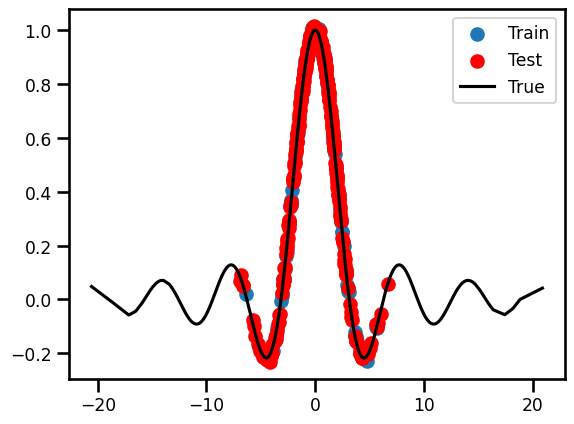

In [4]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color="tab:blue", label="Train")
ax.scatter(x_test, y_test, color="red", label="Test")
ax.plot(x_plot, y_plot, color="black", label="True")

plt.legend()
plt.show()

## Deterministic Neural Networkz

In [12]:
from typing import Any
import jax

def register_params(
    name: str,
    model: Any,
):
    """Register numpyro params for an arbitrary pytree.

    This partitions the parameters and static components, registers the parameters using
    numpyro.param, then recombines them. This should be called from within an inference
    context to have an effect, e.g. within a numpyro model or guide function.

    Args:
        name: Name for the parameter set.
        model: The pytree (e.g. an equinox module, flowjax distribution/bijection).
    """
    params, static = eqx.partition(
        model,
        eqx.is_inexact_array,
        # is_leaf=lambda leaf: isinstance(leaf, wrappers.NonTrainable),
    )
    if callable(params):
        # Wrap to avoid special handling of callables by numpyro. Numpyro expects a
        # callable to be used for lazy initialization, whereas in our case it is likely
        # a callable module we wish to train.
        params = numpyro.param(name, lambda _: params)
    else:
        params = numpyro.param(name, params)
    return eqx.combine(params, static)

In [13]:
key = random.PRNGKey(123)

In [18]:
def nn_model(x, y=None, batch_size=None):
    
    # initialize Model
    net = eqx.nn.MLP(in_size=1, width_size=32, depth=2, out_size=1, key=key)
    
    net = register_params("mlp", net)

    with numpyro.plate("batch", x.shape[0], subsample_size=batch_size):

        batch_x = numpyro.subsample(x, event_dim=0)

        batch_y = numpyro.subsample(y, event_dim=0) if y is not None else None
        mean = jax.vmap(net)(batch_x)

        numpyro.sample("obs", dist.Normal(loc=mean, scale=0.01), obs=batch_y)

In [19]:
guide = autoguide.AutoDelta(nn_model, init_loc_fn=init_to_feasible)

svi = SVI(nn_model, guide, numpyro.optim.Adam(5e-3), TraceMeanField_ELBO())

n_iterations = 10_000

svi_result = svi.run(random.PRNGKey(0), n_iterations, x_train[:, None], y_train.squeeze(), batch_size=32)

params, losses = svi_result.params, svi_result.losses

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_73162/195245116.py:7: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(random.PRNGKey(0), n_iterations, x_train[:, None], y_train.squeeze(), batch_size=32)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8706.42it/s, init loss: 10525273.2671, avg. loss [9501-10000]: 9720483.3983]


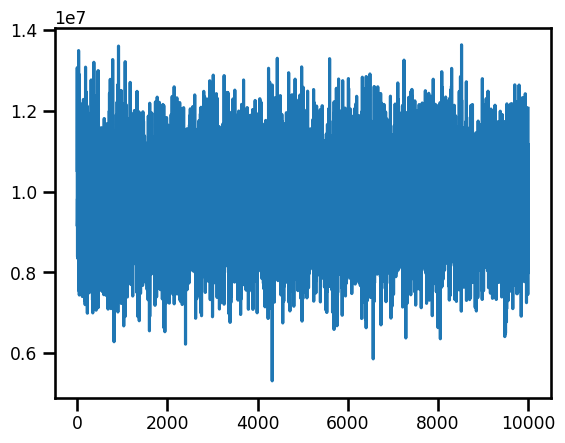

In [20]:
plt.plot(losses)

### Predictions

In [24]:
# initialize predictor
predictive = Predictive(nn_model, guide=guide, params=params, num_samples=1)

# make predictions
y_pred = predictive(random.PRNGKey(1), x_plot[:, None])["obs"].copy()

# # calculate quantile
# y_upper, y_mu, y_lower = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=0)
y_pred.shape

TypeError: nn_model() got an unexpected keyword argument 'parallel'

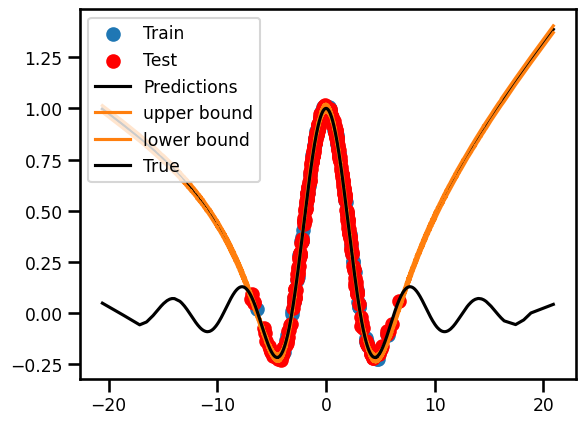

In [10]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color="tab:blue", label="Train")
ax.scatter(x_test, y_test, color="red", label="Test")
plt.plot(x_plot, y_mu, color="black", label="Predictions")
plt.plot(x_plot, y_upper, color="tab:orange", label="upper bound")
plt.plot(x_plot, y_lower, color="tab:orange", label="lower bound")
ax.plot(x_plot, y_plot, color='black', label='True')

plt.legend()
plt.show()

## Probabilistic Neural Network

In [14]:
class Net(nn.Module):

    n_units: int

    @nn.compact
    def __call__(self, x):

        x = nn.Dense(self.n_units)(x[...,None])

        x = nn.gelu(x)

        x = nn.Dense(self.n_units)(x)

        x = nn.gelu(x)

        mean = nn.Dense(1)(x)

        rho = nn.Dense(1)(x)

        return mean.squeeze(), rho.squeeze()

In [50]:
	
def probnn_model(x, y=None, batch_size=None):

    module = Net(n_units=32)

    net = flax_module("nn", module, input_shape=())

    with numpyro.plate("batch", x.shape[0], subsample_size=batch_size):

        batch_x = numpyro.subsample(x, event_dim=0)

        batch_y = numpyro.subsample(y, event_dim=0) if y is not None else None

        mean, rho = net(batch_x)

        sigma = nn.softplus(rho + 1e-10)

        numpyro.sample("obs", dist.Normal(mean, sigma), obs=batch_y)

### Inference

In [51]:
guide = autoguide.AutoNormal(probnn_model, init_loc_fn=init_to_feasible)

svi = SVI(probnn_model, guide, numpyro.optim.Adam(5e-3), TraceMeanField_ELBO())

n_iterations = 50_000

svi_result = svi.run(random.PRNGKey(0), n_iterations, x_train, y_train, batch_size=32)

params, losses = svi_result.params, svi_result.losses

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 12456.77it/s, init loss: 14061679558.3033, avg. loss [47501-50000]: -308.0672]


In [52]:
# initialize predictor
predictive = Predictive(probnn_model, guide=guide, params=params, num_samples=1000)

# make predictions
y_pred = predictive(random.PRNGKey(1), x_plot)["obs"].copy()

# calculate quantile
y_upper, y_mu, y_lower = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=0)

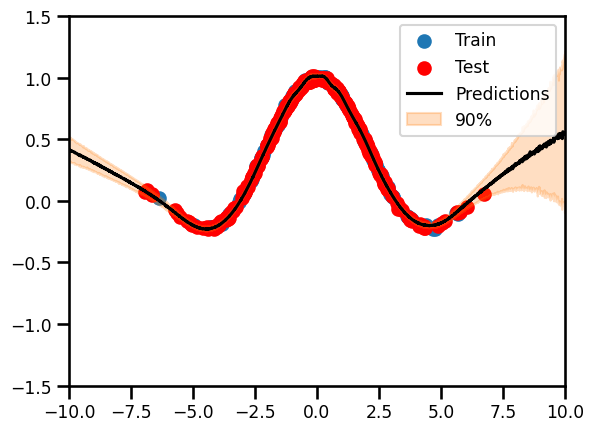

In [53]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color="tab:blue", label="Train")
ax.scatter(x_test, y_test, color="red", label="Test")
plt.plot(x_plot, y_mu, color="black", label="Predictions")
plt.fill_between(x_plot, y_upper, y_lower, color="tab:orange", alpha=0.25, label="90%")
# plt.plot(x_plot, y_lower, color="tab:orange", label="lower bound")
# ax.plot(x_plot, y_plot, color='black', label='True')

ax.set(xlim=[-10,10], ylim=[-1.5, 1.5])
plt.legend()
plt.show()

## Bayesian Neural Network

In [36]:
def bnn_model(x, y=None, batch_size=None):

    module = Net(n_units=16)

    net = random_flax_module("nn", module, dist.Normal(0, 0.01), input_shape=())
    # net = flax_module("nn", module, input_shape=())

    with numpyro.plate("batch", x.shape[0], subsample_size=batch_size):

        batch_x = numpyro.subsample(x, event_dim=0)

        batch_y = numpyro.subsample(y, event_dim=0) if y is not None else None

        mean, rho = net(batch_x)

        sigma = nn.softplus(rho + 1e-10)

        numpyro.sample("obs", dist.Normal(mean, sigma), obs=batch_y)

### Inference

In [37]:
guide = autoguide.AutoNormal(bnn_model, init_loc_fn=init_to_feasible())

svi = SVI(bnn_model, guide, numpyro.optim.Adam(5e-3), TraceMeanField_ELBO())

n_iterations = 30_000

svi_result = svi.run(random.PRNGKey(0), n_iterations, x_train, y_train, batch_size=16)

params, losses = svi_result.params, svi_result.losses

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5367.41it/s, init loss: 16063.8239, avg. loss [28501-30000]: 99.1548]


In [34]:
# initialize predictor
predictive = Predictive(bnn_model, guide=guide, params=params, num_samples=1000)

# make predictions
y_pred = predictive(random.PRNGKey(1), x_plot)["obs"].copy()

# calculate quantile
y_upper, y_mu, y_lower = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=0)

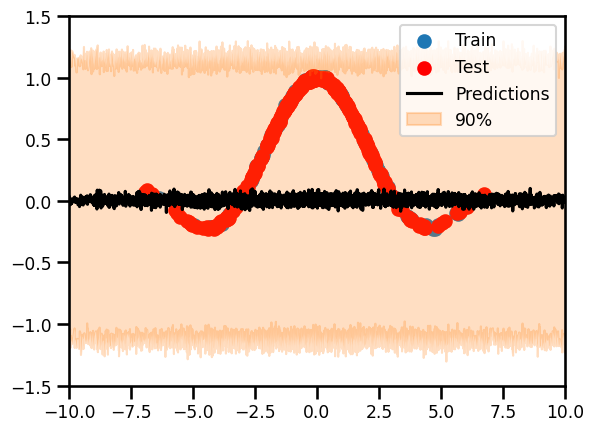

In [35]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color="tab:blue", label="Train")
ax.scatter(x_test, y_test, color="red", label="Test")
plt.plot(x_plot, y_mu, color="black", label="Predictions")
plt.fill_between(x_plot, y_upper, y_lower, color="tab:orange", alpha=0.25, label="90%")
# plt.plot(x_plot, y_lower, color="tab:orange", label="lower bound")
# ax.plot(x_plot, y_plot, color='black', label='True')

ax.set(xlim=[-10,10], ylim=[-1.5, 1.5])
plt.legend()
plt.show()